# III. Convoluted Neural Network (CNN) Modelling
---

This section builds a CNN using both non-augmented and augmented data. I evaluate the performance of the models based on accuracy and loss, and also test the models on a small set of test images.

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from numpy import savetxt
from IPython.display import Image

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# For reproducibility
np.random.seed(42)
from numpy.random import seed
seed(42)

In [2]:
# Mount G-Drive folder.
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [3]:
# Recreate train_ds and val_ds for modelling.

train_df = image_dataset_from_directory(
    '/content/drive/MyDrive/Capstone/images', # Directory
    image_size = (256, 256), # make sure all images are the same size
    batch_size = 32, # This will load 32 images at a time, memory can't hold them all
    seed = 42, # random seed for reproducibility
    validation_split = 0.2, 
    subset = 'training',
    label_mode = 'binary'
)

val_ds = image_dataset_from_directory(
    '/content/drive/MyDrive/Capstone/images',
    image_size = (256, 256),
    batch_size = 32,
    seed = 42,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'binary'
)

Found 1047 files belonging to 2 classes.
Using 838 files for training.
Found 1047 files belonging to 2 classes.
Using 209 files for validation.


---
## CNN Model without data augmentation

---

Below I create a CNN wiith 2 convoluted layers, with early stopping and dropout to help minimize overfitness/maximize performance.

In [4]:
es = EarlyStopping(patience = 5)

In [5]:
# Create base CNN model.
model = Sequential()

model.add(layers.Input(shape = (256,256,3)))\



# The 1. below guarentees a float for the normalization.
model.add(layers.Rescaling(1./255))


# Add first convolution.
model.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Pass into the max pooling layer.
model.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Add second Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten.
model.add(Flatten())

# Add Dropout layer.
model.add(Dropout(.5))

# Fully connected layers.
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#Compile model.
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'],
)

In [6]:
# Fit the model.
base = model.fit(train_df, validation_data= val_ds, epochs = 10, workers = 8, callbacks = [es])

Epoch 1/10
27/27 [==============================] - 75s 2s/step - loss: 0.9155 - accuracy: 0.5632 - val_loss: 0.6082 - val_accuracy: 0.7033
Epoch 2/10
27/27 [==============================] - 1s 27ms/step - loss: 0.5302 - accuracy: 0.7291 - val_loss: 0.4457 - val_accuracy: 0.7799
Epoch 3/10
27/27 [==============================] - 1s 27ms/step - loss: 0.4610 - accuracy: 0.7947 - val_loss: 0.8216 - val_accuracy: 0.6507
Epoch 4/10
27/27 [==============================] - 1s 27ms/step - loss: 0.4152 - accuracy: 0.8055 - val_loss: 0.4335 - val_accuracy: 0.8230
Epoch 5/10
27/27 [==============================] - 1s 28ms/step - loss: 0.2374 - accuracy: 0.9093 - val_loss: 0.4065 - val_accuracy: 0.8469
Epoch 6/10
27/27 [==============================] - 1s 27ms/step - loss: 0.1953 - accuracy: 0.9236 - val_loss: 0.3966 - val_accuracy: 0.8612
Epoch 7/10
27/27 [==============================] - 1s 27ms/step - loss: 0.1179 - accuracy: 0.9535 - val_loss: 0.3446 - val_accuracy: 0.8565
Epoch 8/10
27/

In [7]:
 # Scoring model
print(base.history['loss'][-1], base.history['val_loss'][-1])
print(base.history['accuracy'][-1], base.history['val_accuracy'][-1])

0.04581770673394203 0.3942810595035553
0.9892601370811462 0.8516746163368225


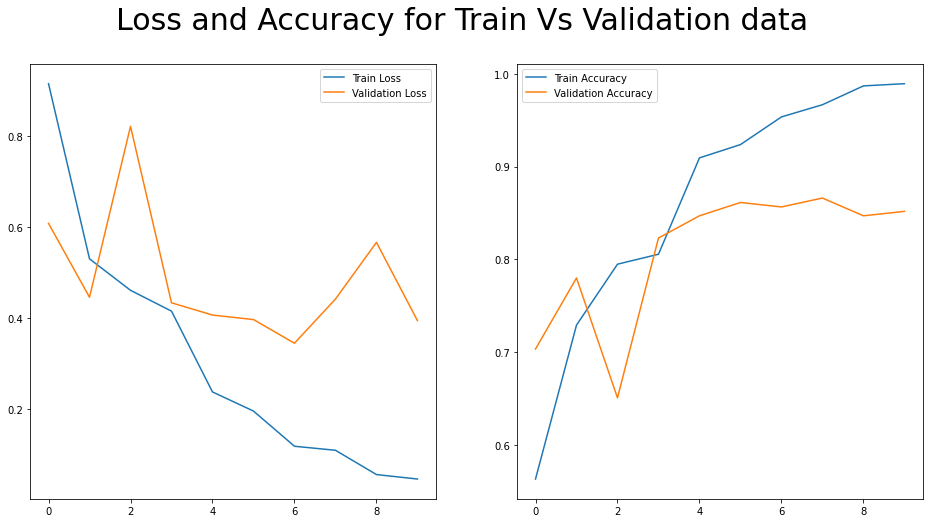

In [8]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Accuracy for Train Vs Validation data', fontsize =30)
figsize=(16,16),
ax1.plot(base.history['loss'], label = 'Train Loss'),
ax1.plot(base.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(base.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(base.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();
plt.savefig('/content/drive/MyDrive/Capstone/figures/no_augmentation_plot')

In [49]:
#Save model as tensor flow type model, for future use in applications (ie. Streamlit).
model.save('/content/drive/MyDrive/Capstone/models/model.h5')

Model is overfit (training set performs better in terms of accuracy compared to validation set). 99% accuracy on the training set is great, but the validatiion set has a significantly lower accuracy of 85%, with a larger loss.

Nonetheless, this base CNN model performs much better than the null model with its accuracy of 50%.

Since dataset is small, can use data augmentation to artificially introduce diversity into the set by flipping images in different orientations.

---
## CNN Model with Data Augmentation

---

This section uses data augmentation to help train the model.

In [9]:
# Instantiate data augmentation.
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Text(0.5, 0.98, 'Bear Scat with Augmentation Applied')

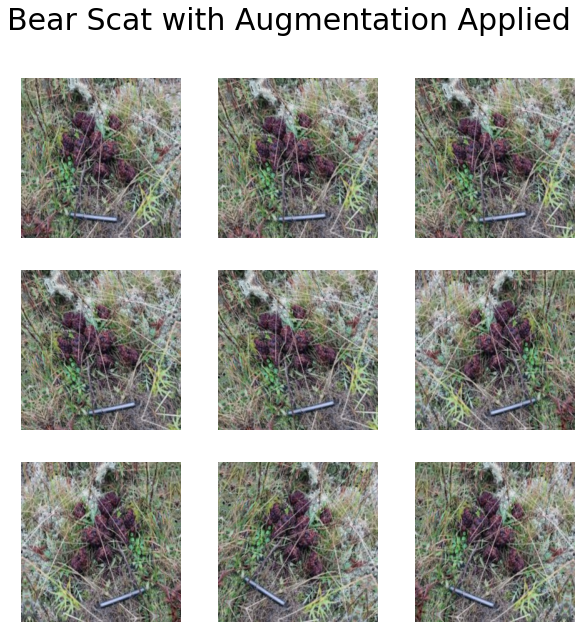

In [10]:
# Plot an image with data augmentation applied.
plt.figure(figsize=(10, 10))
for images, _ in train_df.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.suptitle('Bear Scat with Augmentation Applied', fontsize = 30) 
#plt.savefig('/content/drive/MyDrive/Capstone/figures/image_augmentation')

In [11]:
# Apply `data_augmentation` to the training images. 
train_df = train_df.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetch samples in GPU memory to help maximize GPU utilization. 
train_df = train_df.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Code adapted from [source](https://keras.io/examples/vision/image_classification_from_scratch/).

In [12]:
# Recreate base CNN model, this time using augmented data.
model_2 = Sequential()

model_2.add(layers.Input(shape = (256,256,3)))\



# The 1. below guarentees a float for the normalization.
model_2.add(layers.Rescaling(1./255))


# Add first convolution.
model_2.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Pass into the max pooling layer.
model_2.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Add second Convolution
model_2.add(Conv2D(64, (3,3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

# Flatten.
model_2.add(Flatten())

# Add Dropout layer.
model_2.add(Dropout(.5))

# Fully connected layers.
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

#Compile model.
model_2.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'],
)

In [15]:
# Fitting augmented model with 20 epochs
augmented_base = model_2.fit(train_df, validation_data= val_ds, epochs = 10, workers = 8, callbacks = [es])

Epoch 1/10
27/27 [==============================] - 1s 44ms/step - loss: 0.6931 - accuracy: 0.5095 - val_loss: 0.6936 - val_accuracy: 0.4641
Epoch 2/10
27/27 [==============================] - 1s 44ms/step - loss: 0.6931 - accuracy: 0.5095 - val_loss: 0.6936 - val_accuracy: 0.4641
Epoch 3/10
27/27 [==============================] - 1s 44ms/step - loss: 0.6937 - accuracy: 0.5024 - val_loss: 0.6937 - val_accuracy: 0.4641
Epoch 4/10
27/27 [==============================] - 1s 44ms/step - loss: 0.6931 - accuracy: 0.5095 - val_loss: 0.6936 - val_accuracy: 0.4641
Epoch 5/10
27/27 [==============================] - 1s 43ms/step - loss: 0.6930 - accuracy: 0.5095 - val_loss: 0.6938 - val_accuracy: 0.4641
Epoch 6/10
27/27 [==============================] - 1s 45ms/step - loss: 0.6931 - accuracy: 0.5095 - val_loss: 0.6940 - val_accuracy: 0.4641


In [16]:
# Scoring model
print(augmented_base.history['loss'][-1], augmented_base.history['val_loss'][-1])
print(augmented_base.history['accuracy'][-1], augmented_base.history['val_accuracy'][-1])

0.6930534243583679 0.6939737200737
0.5095465183258057 0.46411484479904175


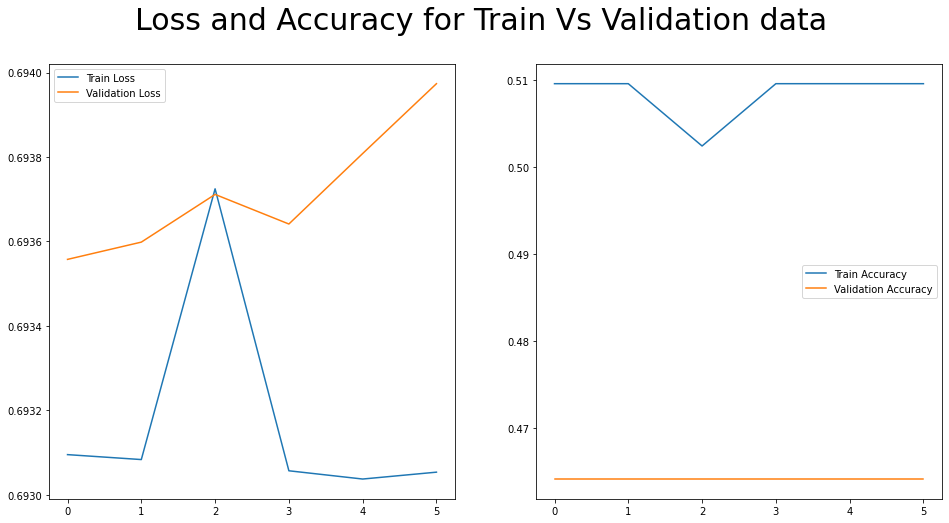

In [17]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Accuracy for Train Vs Validation data', fontsize =30)
figsize=(16,16),
ax1.plot(augmented_base.history['loss'], label = 'Train Loss'),
ax1.plot(augmented_base.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(augmented_base.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(augmented_base.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();
plt.savefig('/content/drive/MyDrive/Capstone/figures/with_image_augmentation')

The model is less overfit due to the augmentation, but performs much worse. In fact, it performs no better than the null model.

---




# Testing CNN model 

---

This section uses a few test images (3 photos of bear scat and 3 of other images) to get an idea of how the model would operate if developped as an application.

### Testing bear scat cases
---

**Bear Scat Test Case 1**

In [18]:
# Turn bear poo image into array to feed into model to predict.
test_img_bear = img_to_array(load_img('/content/drive/MyDrive/Capstone/test_bear/4.jpg'))
test_img_bear.shape

(194, 259, 3)

In [19]:
# Reshape image.
test_img_bear = smart_resize(test_img_bear, (256,256))
test_img_bear.shape

(256, 256, 3)

In [20]:
# Adding extra dimension for model to work.
test_img_bear = np.expand_dims(test_img_bear, axis = 0)
test_img_bear.shape

(1, 256, 256, 3)

In [22]:
# Predict if image is bear scat.
model.predict(test_img_bear)

1/1 [==============================] - 0s 85ms/step


array([[0.99031067]], dtype=float32)

The model is over 99% sure the image contains bear scat.





**Bear Scat Test Case 2**

In [39]:
# Turn bear poo image into array to feed into model to predict.
test_img_bear2 = img_to_array(load_img('/content/drive/MyDrive/Capstone/test_bear/5.jpg'))

# Reshape image.
test_img_bear2 = smart_resize(test_img_bear2, (256,256))

# Add extra dimension for model to work.
test_img_bear2 = np.expand_dims(test_img_bear2, axis = 0)

# Predict if image is bear scat.
model.predict(test_img_bear2)

1/1 [==============================] - 0s 26ms/step


array([[0.50151694]], dtype=float32)

Interestingly, the model is only 50.1% sure this is bear scat, which means it performs only marginally 0.1% better in this test case than the null model.

**Bear Scat Test Case 3**

In [40]:
# Turn bear poo image into array to feed into model to predict.
test_img_bear3 = img_to_array(load_img('/content/drive/MyDrive/Capstone/test_bear/6.jpg'))

# Reshape image.
test_img_bear3 = smart_resize(test_img_bear3, (256,256))

# Add extra dimension for model to work.
test_img_bear3 = np.expand_dims(test_img_bear3, axis = 0)

# Predict if image is bear scat.
model.predict(test_img_bear3)

1/1 [==============================] - 0s 26ms/step


array([[0.99036294]], dtype=float32)

The model is 99% sure this is bear scat, and performs similarly to how it did with the first test case.

### Testing NOT bear scat images
---

**NOT Bear Scat Test Case 1**

In [41]:
# Turn not bear poo image into array to feed into model to predict.
test_img_not = img_to_array(load_img('/content/drive/MyDrive/Capstone/test_not_bear/1.jpg'))
test_img_not.shape

(181, 278, 3)

In [42]:
# Reshape image.
test_img_not = smart_resize(test_img_not, (256,256))
test_img_not.shape

(256, 256, 3)

In [43]:
# Add extra dimension for model to work.
test_img_not = np.expand_dims(test_img_not, axis = 0)
test_img_not.shape

(1, 256, 256, 3)

In [44]:
# Predict if image is bear scat. (since bear scat is our 1 or positive case)
model.predict(test_img_not)

1/1 [==============================] - 0s 29ms/step


array([[0.01030695]], dtype=float32)

The model is 99% sure this is not bear scat.

**NOT Bear Scat Test Case 2**

In [47]:
# Turn not bear poo image into array to feed into model to predict.
test_img_not2 = img_to_array(load_img('/content/drive/MyDrive/Capstone/test_not_bear/2.jpg'))
# Reshape image.
test_img_not2 = smart_resize(test_img_not2, (256,256))
# Add extra dimension for model to work.
test_img_not2 = np.expand_dims(test_img_not2, axis = 0)
# Predict if image is bear scat. (since bear scat is our 1 or positive case)
model.predict(test_img_not2)

1/1 [==============================] - 0s 25ms/step


array([[0.00508749]], dtype=float32)

The model is 99.5% sure this is not bear scat.

**NOT Bear Scat Test Case 3**

In [48]:
# Turn not bear poo image into array to feed into model to predict.
test_img_not3 = img_to_array(load_img('/content/drive/MyDrive/Capstone/test_not_bear/3.jpg'))
# Reshape image.
test_img_not3 = smart_resize(test_img_not3, (256,256))
# Add extra dimension for model to work.
test_img_not3 = np.expand_dims(test_img_not3, axis = 0)
# Predict if image is bear scat. (since bear scat is our 1 or positive case)
model.predict(test_img_not3)

1/1 [==============================] - 0s 27ms/step


array([[0.01993386]], dtype=float32)

The model is 98% sure this is not bear scat.

### Conclusions
---

Although it seemed that our simple CNN model performs decently well, when we actually tested a small sample of images, although 5 of the 6 were classified with great accuracy, the one test case that could not perform significantly better than the null model suggests that the model is not as strong as its accuracy score suggests. 

Indeed, can not be confident that the model would be able to accurately identify an image of bear scat.


### Next Steps
---

In the next section, I attempt a transfer learning model (a pre-trained model) to see if it performs better than my simple CNN model.

---